In [ ]:
##Augment Images
#========================
#This is to step through augmenting the images to prepare the dataset for input into training.

import sys
import os
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
os.chdir('DeepBeachState')
from utils import augment
img_dirs = {'duck':'/home/aquilla/aellenso/Research/DeepBeach/images/north/full/', 'nbn':'/home/aquilla/aellenso/Research/DeepBeach/images/Narrabeen_midtide_c5/daytimex_gray_full/'}


site = 'nbn' #Specify a site, options are 'nbn', 'duck'
labels = 'labels/{}_labels_dict.pickle'.format(site) #input: specify the premade dictionary of labels
labels_augment = 'labels/{}_daytimex_labels_dict_five_aug.pickle'.format(site) #output: filename for labels dictionary with augmented images
img_folder = img_dirs[site] #directory where the images are located
test_filenames = 'labels/{}_daytimex_testfiles.final.pickle'.format(site) #output: list of test dataset filenames
train_val_filenames = 'labels/{}_daytimex_train_val_files.pickle'.format(site) #output: list of training and validation datasets filenames
percent_train = 0.6 
percent_val = 0.2
percent_test = 0.2
augmentations = ['rot', 'flips', 'erase', 'trans', 'gamma'] #specify which augmentations 

F = augment.File_setup(5, img_folder, labels, site)
F.set_up_train_test_val(percent_train, percent_val, percent_test) #Divide the data into the percentages
F.augment_imgs(augmentations) #Augment the images
F.save_train_val(train_val_filenames, test_filenames, labels_augment) #Save out




In [ ]:


#Skill Evaluation
#Global skill (F1), Per-State (Confusion Table)
#================================================
import pickle
from sklearn import metrics 
import matplotlib.pyplot as pl
import numpy as np
import matplotlib.ticker as ticker

with open('model_output/resnet512_train_on_nbn/cnn_preds.pickle', 'rb') as f:
    predictions = pickle.load(f)

class_names = ['Ref', 'LTT', 'TBR', 'RBB', 'LBT']

f1 = []
corrcoeff = []
nmi = []
conf_matrix = []
for testsite in ['duck', 'nbn']: #make sure these names correspond with how they were saved in the predictions pickle
    cnn_preds =  predictions['{}_CNN'.format(testsite)]
    true = predictions['{}_truth'.format(testsite)]
    f1.append(metrics.f1_score(true, cnn_preds, average='weighted'))
    corrcoeff.append(metrics.matthews_corrcoef(true, cnn_preds))
    nmi.append(metrics.normalized_mutual_info_score(true, cnn_preds))
    conf_matrix.append(metrics.confusion_matrix(true, cnn_preds))
    

fig, ax = pl.subplots(3,1, sharex = True, tight_layout = True)
for mi, metric in enumerate([f1, corrcoeff, nmi]):
    ax[mi].bar(range(2), metric)
    ax[mi].set_ylim((0,1))
ax[2].set_xticks(([0, 1]))
ax[2].set_xticklabels(['Duck', 'Nbn'])
ax[0].set_title('F1')
ax[1].set_title('CorrCoeff')
ax[2].set_title('NMI')

cmaps = ['Reds', 'Blues']
fig, axes = pl.subplots(2,1, sharex = True, sharey = True, tight_layout = True)
fig.set_size_inches(6, 9)
for ai, ax in enumerate(axes.ravel('F')):
    confusion_matrix = conf_matrix[ai]/np.sum(conf_matrix[ai], axis = 1)#Turn into percentages
    class_acc = confusion_matrix.diagonal()
    im = ax.pcolor(confusion_matrix, cmap = cmaps[ai], vmin = 0, vmax = 1)

    for row in np.arange(confusion_matrix.shape[0]):
        for col in np.arange(confusion_matrix.shape[1]):
            if row == col:
                mean = class_acc[row]
                if mean >= 0.5:
                    color = 'white'
                else:
                    color = 'black'
                ax.text(col +0.05, row+0.65, '{0:d}%'.format(int(mean*100)), fontsize = 10, fontweight = 'bold', color = color)

            else:
                mean = class_acc[row]
                if mean >= 0.5:
                    color = 'white'
                else:
                    color = 'black'
                ax.text(col +0.05, row+0.65, '{0:d}%'.format(int(mean*100)), fontsize = 10, fontweight = 'bold', color = color)



    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    ax.yaxis.tick_left()
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(class_names))


    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(class_names))


    ax.set_ylabel('Truth', fontsize = 12, weight = 'bold')
    ax.set_xlabel('CNN', fontsize = 12, weight = 'bold')
    #ax.set_title('Test on {0}'.format(testsite, class_acc.mean()))
    cb = fig.colorbar(im, ax = ax)
    cb.ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
    cb.set_label('Accuracy (%)')

axes[0].set_title("Duck")
axes[1].set_title("Nbn")
    


/home/aquilla/aellenso/anaconda3/envs/DeepBS/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


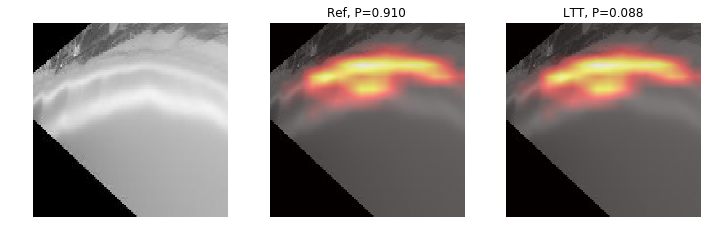

In [5]:
import pickle 
import matplotlib.pyplot as pl
from PIL import Image

imgpath = 'images/example_img.jpg'
imgname = imgpath.split('/')[1][:-4]
ggcampath = '' \
            'model_output/resnet512_train_on_nbn/ggcam_example_img.pickle'
beachstates = ['Ref', 'LTT', 'TBR', 'RBB', 'LBT']


#Load Data
#===============================
with open(ggcampath, 'rb') as f:
    ggcam_dict = pickle.load(f)
img = Image.open(imgpath)
img = img.resize((512,512))

topk = len(ggcam_dict.keys()) - 2
probs = ggcam_dict.pop('probs')
ids = ggcam_dict.pop('ids')

fig, ax = pl.subplots(1, topk + 1, tight_layout = {'rect':[0,0, 1, 0.95]}, figsize = [10,15])
fig.subplots_adjust(0,0,0.9,1)
ax[0].imshow(img, cmap = 'gray')
ax[0].axis('off')

for j, (_, ggcam) in enumerate(ggcam_dict.items()):
    statenum = ids[j]
    prob = probs[j]

    beachstate_string = beachstates[statenum]
    ggcam = ggcam/ggcam.max()
    ax[j + 1].imshow(img, cmap = 'gray')
    ax[j + 1].imshow(img, cmap = 'gray')
    ax[j + 1].axis('off')
    ax[j + 1].imshow(ggcam, alpha = 0.5, cmap = 'hot')
    ax[j + 1].set_title('{0}, P={1:0.3f}'.format(beachstate_string, prob))

pl.show()
